# 6. Deep Learning for Text and Sequences

## Advanced Use of Recurrent Neural Networks

Here, we introduce three advanced techniques for improving the performance and generalisation power of RNNs. We demonstrate these concepts on a **temperature forecasting** problem, where we have access to timeseries of data points from sensors installed on the roof of a building.

The techniques covered are:
- <b>Recurrent dropout</b> - This is a built-in way to use dropout to fight overfitting in recurrent layers
- <b>Stacking Recurrent Layers</b> - This increases the representational power of the network (at the cost of higher computational loads)
- <b>Bidirectional Recurrent Layers</b> - This present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Flatten, Dense, SimpleRNN, LSTM, GRU)

In the **temperature forecasting** problem, we work with a weather timeseires dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany.

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df = df.iloc[:,1:]
df_values = df.values

In [3]:
# For testing
display(df.head(3))
print(df.shape)
print(df.columns)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


(420551, 14)
Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')


This dataset will be used to learn to work with numerical time series. We will use it to build a model that takes in some data in the past as input and predicts the air temperature 24 hours in the future. Each line is a timestep and the readings of the different sensors at that time.

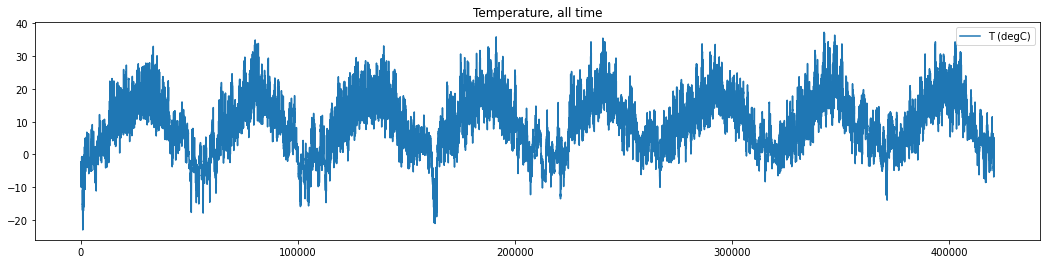

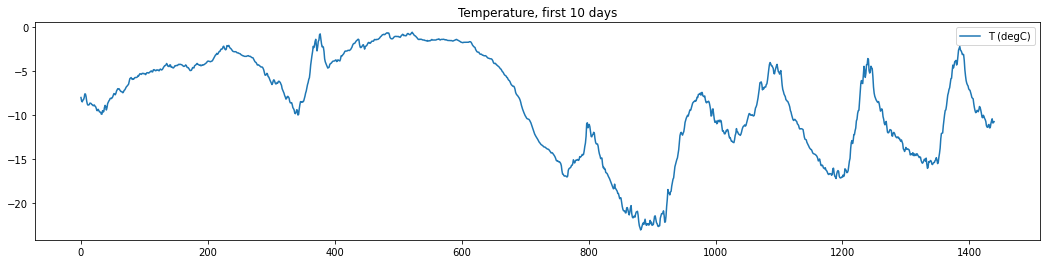

In [4]:
# Plot temperature timeseries for whole period
df.plot(kind='line', y='T (degC)', figsize=(18,4), title="Temperature, all time")
plt.show()
df.iloc[:1440,:].plot(kind='line', y='T (degC)', figsize=(18,4), title="Temperature, first 10 days")
plt.show()

In the 10 days plot, we can see daily periodicity, especially in the last 4 days. Also this is in a cold winter month. If we were trying to predict average temperature for the next month given a few months of past data, the problem would be easy. But looking at the data over a scale of days, the data looks a lot more chaotic. Can we predict time series at a daily scale?

### Problem Statement
The **temperature forecasting** problem is as follows: Given data going as far back as $l$ timesteps, sampled every $f$ steps (that means $n=\frac lf$), can we predict the temperature in $d$ timesteps? E.g. if $l=720, f=6, d=144$, then we have <u>hourly</u> data, up to <u>5 days back</u> (holding <u>120 samples</u>) and want to predict targets <u>24 hours into the future</u>.


In [5]:
# Preprocessing
df_mean, df_std = df_values[:200000].mean(axis=0), df_values[:200000].std(axis=0)
df_values-=df_mean
df_values/=df_std

In [6]:
df_values.shape

(420551, 14)

In [ ]:
# Generator
def generator(data, lookback=0, delay=0, min_index=0, max_index=None, shuffle=False,
              batch_size=128, step=6):
    if max_index == None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i+= len(rows)
        
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows,)))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
LOOKBACK, STEP, DELAY, BATCH_SIZE = 1440, 6, 144, 128

train_gen = generator(df_values, 
                      lookback=LOOKBACK, delay=DELAY, min_index=0, max_index=200000, batch_size=BATCH_SIZE,
                      step=STEP,shuffle=True)
val_gen = generator(df_values, 
                    lookback=LOOKBACK, delay=DELAY, min_index=200001, max_index=300000, batch_size=BATCH_SIZE,
                    step=STEP,shuffle=True)
test_gen = generator(df_values, 
                     lookback=LOOKBACK, delay=DELAY, min_index=300001, max_index=None, batch_size=BATCH_SIZE,
                     step=STEP,shuffle=True)

val_steps = (300000 - 200001 - LOOKBACK)
test_steps = (len(df_values) - 300001 - LOOKBACK)

### Baseline


In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for t in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

This yields an MAE of 0.29. it translates to an average error of $0.29 \times \text{std temperature}$ or $2.57^\circ\text{C}$ which is a fairly large training error.

### v1: MLP Model

Before we work on complicated deep learning models, let's use a simple baseline deep learning model. A model with higher complexity should also deliver a proportionate increase in performance.

For this model, let's use 2 `Dense` layers. Note that there is no activation function in the final layer as we are solving a regression problem.

In [ ]:
# Instantiate Model
###################
clear_session()
model1 = Sequential()
model1.add(Flatten(input_shape=(LOOKBACK//STEP, df_values.shape[-1])))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1))

# Compile
#########
model1.compile(optimizer=RMSprop(), loss='mae',)
print(model1.summary())

In [ ]:
# history1 = model1.fit(train_gen, steps_per_epoch=500, epochs=20, 
#                       validation_data=val_gen, validation_steps=val_steps)

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# metrics_df = pd.DataFrame(history1.history)
# metrics_df['epoch'] = metrics_df.index+1
# display(metrics_df.tail())

# fig = plt.figure(figsize=(17,10))
# ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
# metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
# metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
# ax1.set_ylabel("Loss")
# ax1.grid('GAINSBORO')
# ax1.legend([])
# ax1.set_ylim(0,1.1)
# ax1.set_xticks(range(0,11))

# metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
# metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red',)
# ax2.set_ylabel("Accuracy")
# ax2.grid('GAINSBORO')
# ax2.set_xticks(range(0,11))
# ax2.legend([])
# ax2.set_ylim(0,1.1)
# plt.show()

### v2.1: Recurrent Baseline

The MLP model does not do well, because the model flattened the time series, which removed the notion of time from the input data. Let's look at the data as what it is: a sequence, where order matters. We will use a recurrent-sequence processing model.

This time, we will use the Gated recurrent unit (`GRU`) layer. They use the same principle as LSTM, but are somewhat streamlined and thus cheaper to run (and might not have the same representational power as LSTM). This is a classical tradeoff in ML.

In [ ]:
# Instantiate Model
###################
clear_session()
model2 = Sequential()
model2.add(GRU(32, input_shape=(None, df_values.shape[-1])))
model2.add(Dense(1))

# Compile
#########
model2.compile(optimizer=RMSprop(), loss='mae',)
print(model2.summary())

In [ ]:
history2 = model2.fit(train_gen, steps_per_epoch=500, epochs=20, 
                      validation_data=val_gen, validation_steps=val_steps)

### v2.2: RNN with Dropout
It does seem that the model is overfitting. One of the ways to overcome overfitting is by using dropout, which randomly zeros out input units of a layer.

In [ ]:
# Instantiate Model
###################
clear_session()
model3 = Sequential()
model3.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, 
               input_shape=(None, df_values.shape[-1])))
model3.add(Dense(1))

# Compile
#########
model3.compile(optimizer=RMSprop(), loss='mae',)
print(model3.summary())

### v2.3: Stacking RNN Layers

In [ ]:
# Instantiate Model
###################
clear_session()
model4 = Sequential()
model4.add(GRU(32, dropout=0.1, recurrent_dropout=0.5,
               return_sequences=True,
               input_shape=(None, df_values.shape[-1])))
model4.add(GRU(64, activation='relu', dropout=0.1, 
               recurrent_dropout=0.5))
model4.add(Dense(1))

# Compile
#########
model4.compile(optimizer=RMSprop(), loss='mae',)
print(model4.summary())

### v2.4: Using Bidirectional RNN

In [ ]:
# Instantiate Model
###################
clear_session()
model5 = Sequential()
model5.add(GRU(32, dropout=0.1, recurrent_dropout=0.5,
               return_sequences=True,
               input_shape=(None, df_values.shape[-1])))
model5.add(GRU(64, activation='relu', dropout=0.1, 
               recurrent_dropout=0.5))
model5.add(Dense(1))

# Compile
#########
model4.compile(optimizer=RMSprop(), loss='mae',)
print(model4.summary())